<h1 style="text-align: center;"> Preprocesamiento </h1>
<h1 style="text-align: right; font-size: 24px; margin-right: 10px;">Guillermo Díaz Aguado</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Introducción
Uno de los factores más importantes a la hora de crear nuestro modelo de aprendizaje es que nuestros datos tengan información de calidad y una buena cantidad. Es por ello que vamos a indicar una serie de pasos que se deberían hacer *SIEMPRE* antes de empezar a crear nuestro modelo. 

## Primeros pasos al obtener una base de datos.
Antes de empezar a hacer cualquier cosa con los datos, deberíamos verificar que cada variable es como debería ser. Algunos ejemplos de variables que no deberían ser son:

### Uso de caracteres en variables númericas.
El primer paso que debemos verificar es que todas las columans son del tipo que deberían ser, si en alguna columna que debería ser númerica, nos dicen que es un `objeto` eso es porque se ha colado algo que no debría estar ahí (o que nos estan dando información extra)

In [2]:
df = pd.DataFrame({
    "precio": [100, 200, 150, "230$", 300, 220, 250],
    "opcion": ["tiene","no tiene","tiene","no tiene","tiene","no tiene","tiene"]
})
print(f" El tipo de nuestra columna del database es {df.dtypes.iloc[0]}")

# Crear columna booleana que indica si el valor contiene "$"
df["tiene_dolar"] = df["precio"].astype(str).str.contains("$")

# Limpiar la columna 'precio' quitando el símbolo '$' y convertir a numérico
df["precio_limpio"] = df["precio"].astype(str).str.replace(r"\$", "", regex=True).astype(float)

df


 El tipo de nuestra columna del database es object


,precio,opcion,tiene_dolar,precio_limpio
0,100,tiene,True,100.0
1,200,no tiene,True,200.0
2,150,tiene,True,150.0
3,230$,no tiene,True,230.0
4,300,tiene,True,300.0
5,220,no tiene,True,220.0
6,250,tiene,True,250.0


### Columna que es binaria tiene valores de caracteres
Esto es algo tan sencillo como aplicar el siguiente codigo:

In [3]:
# Reemplazar "tiene" por 1 y "no tiene" por 0
df["opcion"] = df["opcion"].map({"tiene": 1, "no tiene": 0})

### Saber cuantos valores únicos hay en cada columna para convertirla en categorica

In [4]:
df.nunique()



def analizar_variables_categoricas(datos, numero_grupos_max=250):
    """
    Analiza variables categóricas en un DataFrame.

    Args:
        datos (DataFrame): El DataFrame que contiene los datos.

    Returns:
        dict: Un diccionario donde aparecen las diferentes categorias, sus frecuencias
        absolutas y relativas.
    """
    # Inicializar un diccionario para almacenar los resultados
    resultados = {}
    frecuencias = []
    variables_aceptadas = []
    
    # Genera una lista con los nombres de las variables.
    variables = list(datos.columns) 
    
    # Seleccionar las columnas numéricas en el DataFrame
    # numericas = datos.select_dtypes(include=['int', 'int32', 'int64','float', 'float32', 'float64']).columns

    # Seleccionar las columnas categóricas en el DataFrame
    # categoricas = [variable for variable in variables if variable not in numericas]
    
    # Iterar a través de las variables categóricas

    for variable in variables:
            serie_con_cada_frecuencia = datos[variable].value_counts()

            if len(serie_con_cada_frecuencia)<numero_grupos_max:
                resumen = pd.DataFrame({
                    'n': serie_con_cada_frecuencia,             # Conteo de frecuencias
                    '%': datos[variable].value_counts(normalize=True)  # Porcentaje de frecuencias
                })
                variables_aceptadas.append(variable)
                frecuencias.append(resumen)
                resultados[variable] = resumen  # Almacenar el resumen en el diccionario

    final = pd.concat(frecuencias, keys=variables_aceptadas) 
    # print(final)
    return final

## Gestión de valores perdidos
A la hora de recopilar datos pueden ocurrir muchos fallos (o no tienen por qué ser fallos) que hagan que nuestro dataset tengan valores perdidos, nulos. Estos datos se pueden deber a decenas de factores como: 
| Tipo de dato faltante | Descripción |
|------------------------|-------------|
| Simplemente se han perdido aleatoriamente al llegar a nuestra mano | Generalmente debido a la aleatoriedad, con lo que no afectan en gran medida |
| Se han dejado sin contestar | En casos como estos nos pueden dar información extra, ya que es posible que se hayan dejado sin contestar debido a factores que influyen sobre la variable dependiente. Una buena solución a estos elementos es crear una nueva variable dicotómica que nos indique si han dejado sin contestar o no dicho espacio |

Desafortunadamente, estos valores son casi imposibles de manejar para la mayoria de las herramientas computacionales, es por ello que debemos tratarlas antes. Los valores perdidos se pueden mostrar de infinitas formas, lo optimo sería que nos diesen alguna pista al recibir el datset, pero sabemos que eso muchas veces es imposible, por lo que muestro algunos ejemplos:
* Valor NaN
* Valor null
* Celda vacía
* Celda con caracteres en una columna con valores numericos
* Caracteres como "?"
* Valores excesivamente altos como 9999 o valores extraños como 0 o -1

Como se puede imaginar, el modelo creado con algunos de estos valores estaría mal hecho (o incluso ni se podría generar). Es por ello que voy a implementar una función para detectar estos valores y convertilos en valores nulos para que en un paso posterior se haga lo que se crea conveniente

### Código para borrar los valores perdidos

In [5]:
def search_transfnan(df, columna, value, nan=np.nan):
    """ 
    Convierte en la columna expresada los valores que deberian ser NaN en NaN.

    En caso de que value sea un diccionario, aplicará un condicional a estos valores.
    """
    if type(value)==dict:
        value = value.items()

        if value[0]=="$gt":
            df[columna] = df[columna].where(df[columna]>value, nan)
        elif value[0]=="$gte":
            df[columna] = df[columna].where(df[columna]>=value, nan)
        elif value[0]=="$lt":
            df[columna] = df[columna].where(df[columna]<value, nan)
        elif value[0]=="$lte":
            df[columna] = df[columna].where(df[columna]<=value, nan)

    else:
        df[columna] = df[columna].replace(value, nan)


def missing_as_nan(df, lista_nulos=[], diccionario_nulos={}):
    """
    Convierte los valores que deberian ser nulos a valores np.nan

    En caso de lista_nulos==True entonces todos los valores de lista nulos se consideraran que deberían
    ser NaN y se aplica a todas las columnas

    En caso de diccionario_nulos==True las llaves del diccionario indicaran a que columna aplicar los 
    valores que deberian ser NaN en los valores de estos diccionearios.
    """
    if diccionario_nulos:
        items = list(diccionario_nulos.items())

        for pair in items:
            if type(pair[1])==list:
                for element in pair[1]:
                    search_transfnan(df, pair[0], element)
            else:
                search_transfnan(df, pair[0], pair[1])

    if lista_nulos:
        columnas = df.columns
        for value in lista_nulos:
            for columna in columnas:
                search_transfnan(df, columna, value)


## Gestión de valores atípicos (Outliers).
Los valores atípicos o *Outliers* son observaciones que se devían significativamente del resto de datos. Son inusuales en comparación con otras observaciones y pueden deberse a **errores de medición**, **entradas incorrectas** o **EVENTOS EXCEPCIONALES REALES**.

* <span style="color:salmon;">Es importante detectarlos y analizarlos ya que podrían ser ERRORES o DATOS VALIOSOS</span>

Estos valores son importantes identificarlos porque:
* Pueden distorsionar estadísticas como la media o la desviación estándar
* Pueden afectar negativamente al rendimiento de algunos modelos, haciendolos menos precisos o generalizables.

### ¿En que modelos de Machine Learning afectan?
| Modelos sensibles a los outliers | ¿Por qué?|
|-----|-----|
| Regresión lineal | |
| K-Nearest Neighbors (KNN) | |
| SVM con kernels lineales | |
| Redes neuronales | |

En cambio hay otros modelos que pueden manejar los valores atípicos

| Modelos más robustos a outliers (aunque pueden verse afectados si los outliers son muy dominantes) | |
|------|-----|
| Árboles de decisión | |
| Random forest | |
| Gradient Boosting | |

### Formas para detectar Outliers.
| Nombre | Que hace | Formula | Ventajas | Desventajas |
|-|-|-|-|-|
| Rango intercuartilico (IQR) | Mide el rango entre el primer y tercer caurtil (Q1 y Q3) y marca como outliers los valores que estén fuera de ese rango multiplicado por un valor (en este caso 1.5) | $$ \text{Outlier} = \left\{ \begin{array}{ll} x < Q1 - 1.5 \times IQR & \text{(Inferior a la regla de corte)} \\ x > Q3 + 1.5 \times IQR & \text{(Superior a la regla de corte)} \end{array}\right. $$ | * Rapido y simple <br> * No asume distribución normal | * Solo para variables númericas individuales |
| Z-Score | Calcula cuántas desviaciones estándar está un punto respecto a la media. | Si \|z\| > 3, se considera outlier. | * Útil cuando los datos siguen una distribución normal | * Muy sensible a valores extremos (puede fallar si ya hay outliers) <br>* Supone simetría en la distribución.| 
| Isolation Forest | Modelo basado en árboles que "aísla" observaciones. Los outliers se aíslan más rápido (menos divisiones necesarias). | | * Funciona bien con datos de alta dimensión <br> * No necesita etiquetar los datos <br> * Escalable y rápido | * Tiene un hiperparámetro importante: `contamination` |



### Código para detectar los valores atípicos
#### Atípicos mediante Rango intercuartílico

In [17]:
def rango_intercuartilico(series):
    # Calculo el Q1, el Q3 y el IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Establezco los limites para detectar outliers
    lim_inf = Q1 - 1.5*IQR
    lim_sup = Q3 + 1.5*IQR

    #Detecto los valores atipicos
    outliers = ((series<lim_inf) | (series>lim_sup)).astype(int)
    print(outliers)




data = {
    'valor': [10, 12, 15, 14, 100, 18, 25, 30, 55, 60, 250, 35, 40]
}
df = pd.DataFrame(data)
rango_intercuartilico(df["valor"])


0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    1
11    0
12    0
Name: valor, dtype: int32


#### Atípicos mediante Z-score

In [7]:
def zscore_outliers(series, umbral=3):
    media = series.mean()
    std = series.std()

    z_scores = (series - media) / std
    return (z_scores.abs() > umbral).astype(int)

# print(zscore_outliers(df["valor"]))


#### Atípicos mediante Isolation Forest

### Función completa



## Preprocesamiento de variables categoricas.
### Introducción 
Muchas librerias necesitan que las clases de las variables categóricas se codifiquen como valores enteros. Aunque ya muchas librerias convierten algunos de esots tipos de variables a valores enteros (de forma interna), se considera buena práctica hacerlo nosotros manualmente.
Tendremos 2 tipos de variables categoricas.

| Nombre | Descripción | Ejemplo |
| ------ | ----------- | ------- |
| <span style="color:lightblue;">Variable ordinal</span>| Son variables que tienen un orden, pero que en la base de datos no se muestra| L>M>S>XS|
| <span style="color:lightblue;">Variable nominal</span> | Son variables que no se pueden ordenar. Solo se puede ser de un tipo o de varios | Colores |

### Variables ordinales 
Para poder trabajar con ellas sería necesario convertirlos a números enteros. 
La relación entre todas las etiquetas se debe poder expresar como una ecuación. Esta relación se debería indicar en el enunciado o se debe encontrar. 
$$
\text{Ejemplo:  } \text{XL}= \text{L}+2 = \text{M}+5 = \text{S}+7 \quad \Rightarrow \quad 
\left\{
\begin{array}{l}
  XL = 8 \\
  L = 6 \\
  M = 3 \\
  S = 1
\end{array}
\right.
$$
Para poder realizar el cambio, tan solo habría que aplicar un *mapping* a toda la columna, usando un diccionario de referencia. 

In [8]:
df = pd.DataFrame({"size":["L", "M", "L", "XL", "S"]})

size_mapping = {"XL": 8,
                "L": 6,
                "M": 3,
                "S": 1}

df["size"] = df["size"].map(size_mapping)
df

,size
0,6
1,3
2,6
3,8
4,1


### Variables nominales. 
Hay dos formas de realizar el preprocesamiento.
* **LabelEncoder**
* **One Hot Encoder**
#### LabelEncoder.
Sabiendo que son etiquetas que no siguen ningún orden, podemos darle un valor aleatorio a cada etiqueta y ya se quedaría como números enteros, tan solo debemos tratarlos después como "etiquetas" en números enteros.
* <span style="color:salmon;">Desventajas</span>
    * En el caso de que se pueda ser de varias clases a la vez, sus valores númericos no se podrán "sumar", ya que le hemos dado valores arbitrarios.
    * No se pueden usar como valores en regresiones, ya que al ser valores arbitrarios estariamos asumiendo que un valor es mayor que otro, cuando, en realidad, simplemente son distintas clases.
* <span style="color:salmon;">Ventajas</span>
    * Ocupa solo 1 columna, con lo que no se necesitas más espacio de almacenamiento ni tarda tanto en formarse el modelo

##### Ejemplo de LabelEncoder.

In [9]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Supongamos que tenemos una columna de tallas
df = pd.DataFrame({
    'size': ['L', 'M', 'L', 'XL', 'S', 'M', 'S']
})

# Creamos el codificador
encoder = LabelEncoder()

# Aplicamos el codificador
df['size_encoded'] = encoder.fit_transform(df['size'])

# Mostramos el resultado
df

,size,size_encoded
0,L,0
1,M,1
2,L,0
3,XL,3
4,S,2
5,M,1
6,S,2


#### One Hot Encoding.
Otro proceso sería generando una **variable dummy** para cada una de las clases de estas variables. Donde daremos el valor "1" si pertenece a la clase de esa columna y "0" en caso contrario.
Es importante destacar que en el caso de *variables nominales exclusivas* (son aquellas que solo pueden ser de 1 clase) **se debe eliminar 1 de las posibles columnas nuevas, ya que si tienes las demás columnas de las clases, la última se puede deducir a partir de estas**. En caso de no eliminarse, habrá <span style="color:salmon;">COLINEALIDAD</span>.

* <span style="color:salmon;">Ventajas</span>
    * Se puede usar en problemas de regresión.
    * Puedes codificar variables que pertenecen a varias clases.
* <span style="color:salmon;">Desventajas</span>
    * Generarás muchas nuevas columnas, que deberán ser guardadas y procesadas -> Mayor espacio y tiempo


##### Ejemplo de One Hot Encoding
La forma más directa de hacerlo es usando la función de pandas **get_dummies**

In [10]:
df_encoded = pd.get_dummies(df, columns=["size"])
df_encoded

,size_encoded,size_L,size_M,size_S,size_XL
0,0,True,False,False,False
1,1,False,True,False,False
2,0,True,False,False,False
3,3,False,False,False,True
4,2,False,False,True,False
5,1,False,True,False,False
6,2,False,False,True,False


## Escalado de las variables independientes.
El escalado de los datos es un punto tan importante, que para algunos modelos estadisticos es NECESARIO aplicar una transformación de escalado para que este algoritmo funcione.

Prácticamente siempre habrá que usar un escalado, que de manera general, no empeora el modelo. Pero, ¿Para que sirve?
    Pongamonos en el caso que queremos hacer un modelo con estos rangos de variables independientes: $X_1:[0-100]$ y $X_2:[1.000-1.000.000]$.
    Seguramente la variable $X_2$ tendrá un mayor peso en el modelo, debido únicamente a la escala de esta variable y no debido a la posible correlación de la variable predictora $X_2$ con la variable dependiente Y.





<p style="color: lightblue;">El método usado para todas las posibles tranformaciones de escalado en Sklearn sigue los mismos pasos</p>


| Acción                                                         | Código                                   |
|---------------------------------------------------------------|------------------------------------------|
| Generas el objeto del escalador | `X_new = StandardScaler()`               |
| Transformas las variables con el método<span style="color:salmon;">  .fit_transform</span> | `X_new.fit_transform(X)`                |

<span style="color:lightblue;">En caso de tener *train* y *test*</span>
|                                                         |                                  |
|---------------------------------------------------------------|------------------------------------------|
| Generas el objeto  | `mms = MinMaxScaler()`               |
| Usamos los datos de test para calcular los parametros del escalado (<span style="color:salmon;">  .fit</span>) y transformamos esos datos (<span style="color:salmon;">  transform</span>)-><span style="color:salmon;">  .fit_transform</span> | `X_train_scaled = mms.fit_transform(X_train)`                |
| Transformamos los datos de test pero con los parametros del training | `X_test_scaled = mms.transform(X_train)`|

### Tipos de escalado
| Técnica | Descripción | Fórmula |
|--------|-------------|---------|
| <span style="color:lightblue;">Normalización</span> (MinMaxScaler) | Se reescalan los datos en un rango de 0 a 1. Donde 0 es el mínimo y 1 es el máximo. | $x_{\text{norm}}^{(i)} = \frac{x^{(i)} - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}$ |
| <span style="color:lightblue;">Estandarización </span> (StandardScaler) | <p style="text-align:center;">Hace que los datos se queden con media=0 y std.desv=1 </p> <div style="text-align: center;font-size:24px;">↓</div>  <p style="color:lightblue;text-align: center;">Mantiene la forma original de los datos, tan solo los "centra" y "estira" </p><div style="text-align: center;font-size:24px;">↓</div>  <p style="color:salmon; text-align: center;"> Los outliers influyen mucho </p>| $x_{\text{std}}^{(i)} = \frac{x^{(i)} - \mu_{\text{x}}}{\sigma_{\text{x}}}$ |
| <span style="color:lightblue;">QuantileTransformer </span> (QuantileTransformer) | <p style="text-align:center;">Asigna cauntiles a cada valor y crea una distribución normal(por defecto media=0, std.desv=1) </p> <div style="text-align: center;font-size:24px;">↓</div>  <p style="color:lightblue;text-align: center;"> Cambia la distribución </p><div style="text-align: center;font-size:24px;">↓</div>  <p style="color:salmon; text-align: center;"> Los outliers se comprimen </p> <div style="text-align: center;font-size:24px;">↓</div>  <p style="color:salmon; text-align: center;"> Se elimina el sesgo por distribución o distorsión </p> | <img src="Imagenes_Preprocesamiento/Representacion_QuantileTransformer.png" alt="Quantile Transformer" width="400"/> |
| <span style="color:lightblue;">RobustScaler </span> (RobustScaler) | <p style="text-align:center;"> Escala los datos de forma robusta frente a los OUTLIERS, usa la mediana y el rango intercuartilico (IQR) que son menos sensible a los valores atipicos </p> <div style="text-align: center;font-size:24px;">↓</div>  <p style="color:lightblue;text-align: center;"> No se si cambia la distribución </p><div style="text-align: center;font-size:24px;">↓</div>  <p style="color:salmon; text-align: center;"> Robusto frente a los outliers </p> <div style="text-align: center;font-size:24px;">↓</div>  <p style="color:salmon; text-align: center;"> Util si los datos tienen valores extremos que no queremos eliminar </p> | $x_{\text{robust}}^{(i)} = \frac{x^{(i)} - \text{Mediana}}{\text{IQR}}$ |



### Ejemplo 1 de uso en Scikit Learn

In [11]:
df = pd.read_csv("Datasets_Preprocesamiento/drawndata1.csv")
df.head()

,x,y,z
0,58.080365,225.699042,a
1,238.867357,247.456645,a
2,156.218212,286.588782,a
3,262.004361,284.251445,a
4,185.243183,308.187571,a


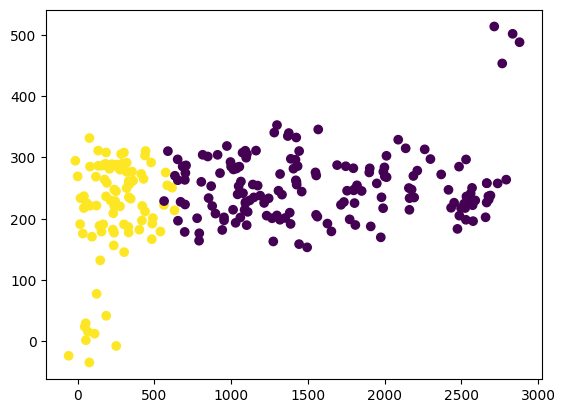

In [12]:
X = df[["x", "y"]]
Y = df["z"] == "a" # Hago que la serie Y sea True si z=a y false en caso contrario.
plt.scatter(X["x"], X["y"], c=Y)

Como podemos ver en los datos anteriores, existen varios problemas:
* La escala:
    * El eje x va de 0 a 3000
    * El eje y va de 0 a 500
    * Esto puede provocar que los pesos de las predicciones dependan de las escalas de estas, cosa que no queremos.
* Los valores atípicos:
    * Existen valores atípicos que están lejos de donde deberían estar.


Si usamos el StandardScaler podemos resolver el problema de la *escala*, pero si usamos el Quantile transformer podemos resolver el problema de la *escala* y el problema de los *valores atípicos*.

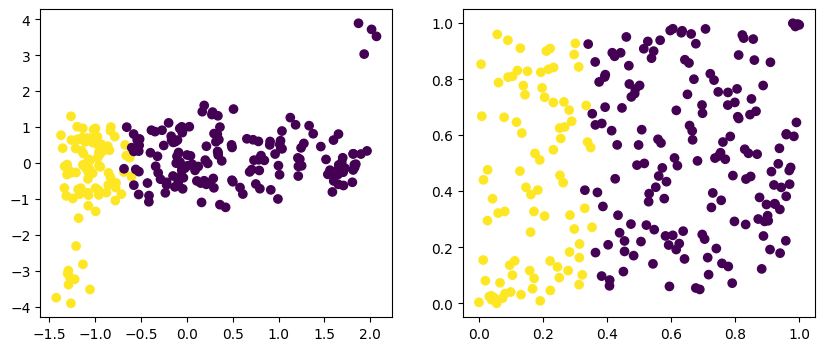

In [13]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

X_standard = StandardScaler().fit_transform(X)
X_quantile = QuantileTransformer(n_quantiles=100).fit_transform(X) # Pongo el numero de quantiles para que no salga el Warning

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(X_standard[:, 0], X_standard[:, 1], c=Y)
ax[1].scatter(X_quantile[:, 0], X_quantile[:, 1], c=Y)

Ahora vamos a usar un ejemplo usando la predicción de **KNNeighbours**, donde podremos notar que mas robusto usar uno de estos dos métodos

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


def plot_output(scaler, X, y):
    pipe = Pipeline([
        ("scale", scaler),
        ("model", KNeighborsClassifier(n_neighbors=20, weights='distance'))
    ])

    X = X.to_numpy()
    y = y.to_numpy()

    pred = pipe.fit(X, y).predict(X)

    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Original Data")
    plt.subplot(132)
    X_tfm = scaler.transform(X)
    plt.scatter(X_tfm[:, 0], X_tfm[:, 1], c=y)
    plt.title("Transformed Data")
    plt.subplot(133)
    X_new = np.concatenate([
        np.random.uniform(0, X[:, 0].max(), (5000, 1)), 
        np.random.uniform(0, X[:, 1].max(), (5000, 1))
    ], axis=1)
    y_proba = pipe.predict_proba(X_new)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=y_proba[:, 1], alpha=0.7)
    plt.title("Predicted Data")

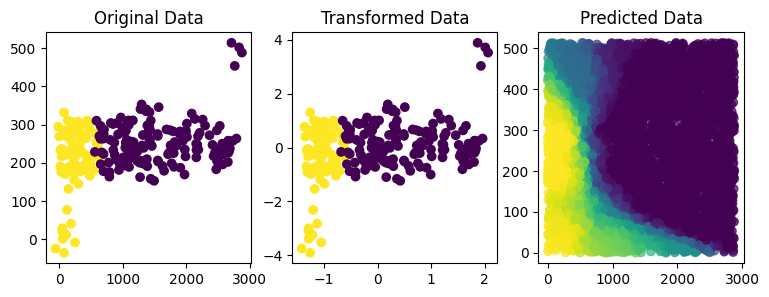

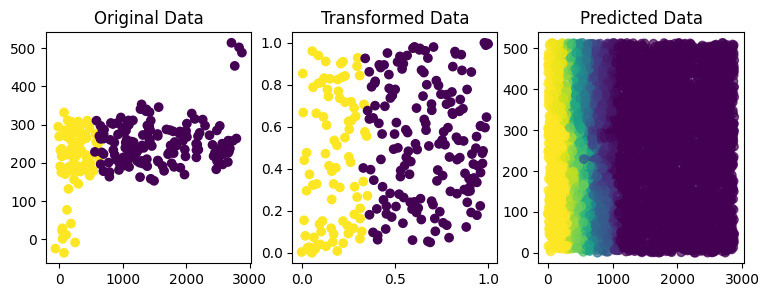

In [15]:
plot_output(StandardScaler(), X, Y)
plot_output(QuantileTransformer(n_quantiles=100), X, Y)

### Ejemplo 2 División de muestras no lineales.

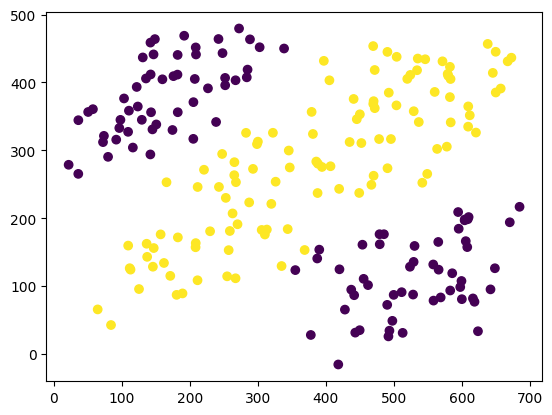

In [16]:
df = pd.read_csv("Datasets_Preprocesamiento/drawndata2.csv")
X = df[["x", "y"]].values   # Esta vez voy a usar arrays de numpys en vez de usar dataframes
Y = df["z"] == "a" 
plt.scatter(X[:, 0], X[:, 1], c=Y)

# División de datos.
En la mayoría de los procesos de aprendizaje supervisado nosotros usaremos una parte de los datos para entrenar el modelo **TRAIN** y otra parte de los datos para verificar que el modelo que hemos creado es bueno **TEST**. Esto es <span style="color: IndianRed;">IMPRESCINDIBLE</span> para calibrar nuestro modelo, ya que nos da información sobre posible:
* Overfitting
* Poca accuracy
* Aprenda de datos anomalos

### <span style="color: lightblue;">Datos de entrenamiento (Training data)</span>

Son los datos que usamos para entrenar un modelo. La **calidad del modelo** está direcatamente relacionada con la **calidad** de los datos de entrenamiento. Es NECESARIO e IMPRESCINDIBLE llevar a cabo un proceso de *depuración y limpieza* de datos de iniciar el ajuste del modelo

Es **Importante** que el conjunto de datos de datos de prueba tenga un **volumen suficiente** como para generar resultados estadisticamente significativos, y a la vez, que sea representativo del conjunto de datos global.

### <span style="color: lightblue;">Datos de validación (Test data)</span>

Son los datos reservados para comprobar si el modelo que hemos generado a partir de los *datos de entrenamiento* funciona, esto es que las respuestas predichas son acertadas o no.

## Problemas que pueden surgir.
### Sobreajuste u overfitting
Ocurre cuando el modelo esta "sobre-entrenado". Ocurre en modelo complejos que se ajustan tan exactamente al conjunto de datos de entrenamiento a partir del cual se ha creado, que **no se generalizan bien a los datos de test, perdiendo gran parte de su capacidad predictiva**. Esto se debe a la variabilidad de los datos, al ajustarse demasiado a cada una de las muestras de los datos, el modelo aprende de la variabilidad, algo que impide la generalización .

### Datos anomalos.
Cuando un sistema de Machine Learning se entrena demasiado con datos anomalos, provoca que el algoritmo *aprenda* **patrones que no son generales** y caracteristicas que son demasiado especificas. 
